# This Example shows how to classify EuroSAT satellite images using the deep learning model DeepSAT-V2.

Find the details of the DeepSAT-V2 model in the <a href="https://arxiv.org/abs/1911.07747">corresponding paper</a>

Find the details of the dataset <a href="https://github.com/phelber/EuroSAT">here</a>

### EuroSAT satellite dataset contains images from 10 different classes:

<ul>
<li>Annual Crop</li>
<li>Forest</li>
<li>Herbaceous Vegetation</li>
<li>Highway</li>
<li>Industrial</li>
<li>Pasture</li>
<li>Permanent Crop</li>
<li>Residential</li>
<li>River</li>
<li>SeaLake</li>
</ul>

### 13 Spectral bands of a highway image

<img src="sample-figure/euro-highway.png" />

### 13 Spectral bands of an industry image

<img src="sample-figure/euro-industry.png" />

### Import Modules and Define Parameters

In [ ]:
from geotorchai.datasets.raster import EuroSAT
full_data = EuroSAT(root="data/eurosat", download=True, include_additional_features=True)

In [1]:
import sys
import os
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from geotorchai.models.raster import DeepSatV2
from geotorchai.datasets.raster import EuroSAT
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [14]:
## Define parameters
epoch_nums = 10
learning_rate = 0.0002
batch_size = 16
validation_split = 0.2
shuffle_dataset = True
random_seed = int(time.time())
params = {'batch_size': batch_size, 'shuffle': False}

## make sure that PATH_TO_DATASET exists in the running directory
PATH_TO_DATASET = "data/eurosat"
MODEL_SAVE_DIR = "model-deepsatv2"
MODEL_SAVE_PATH = MODEL_SAVE_DIR + "/deepsatv2.pth"
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

### Load Data and Add Normalization Transformation

In [3]:
## load data and calculate mean and std to perform normalization transform
## Set download=True if dataset is not available in the given path
fullData = EuroSAT(root = PATH_TO_DATASET, download=False)

full_loader = DataLoader(fullData, batch_size= batch_size)
channels_sum, channels_squared_sum, num_batches = 0, 0, 0
for i, sample in enumerate(full_loader):
    data_temp, _ = sample
    channels_sum += torch.mean(data_temp, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data_temp**2, dim=[0, 2, 3])
    num_batches += 1

mean = channels_sum / num_batches
std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

In [4]:
## Define the transform operation
sat_transform = transforms.Normalize(mean, std)
## Load data with desired transformation and additional handcrafted features enabled
fullData = EuroSAT(root = PATH_TO_DATASET, include_additional_features = True, transform = sat_transform)

### Get All Class Names and Corresponding Labels

In [5]:
## find all class names and corresponding labels
print(fullData.get_class_labels())

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


### Display Spectral Bands of the First Image

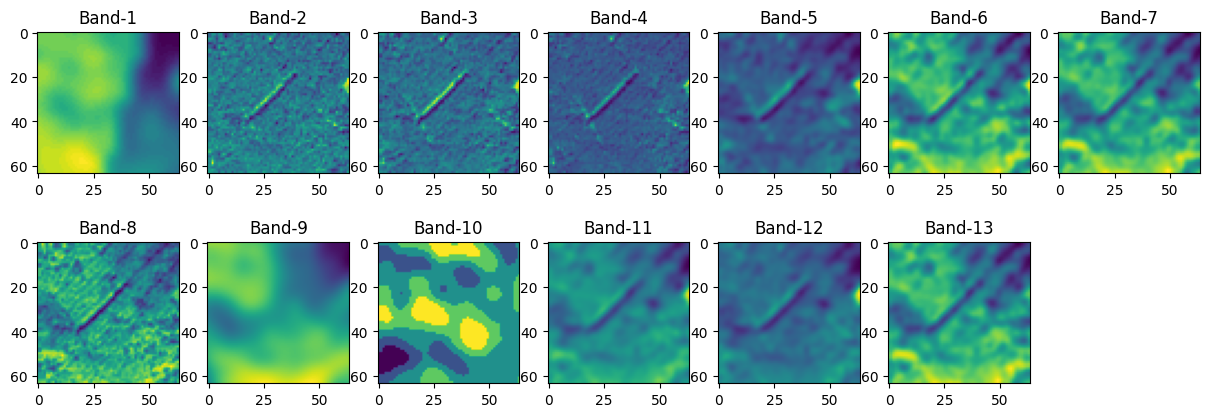

In [6]:
## Display various bands from an input image
input_data, label, features = fullData[1]
f, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7), (ax8, ax9, ax10, ax11, ax12, ax13, ax14)) = plt.subplots(2, 7, figsize=(15,5))
ax14.axis('off')
        
ax1.set_title('Band-1')
ax1.imshow(input_data[0])

ax2.set_title('Band-2')
ax2.imshow(input_data[1])

ax3.set_title('Band-3')
ax3.imshow(input_data[2])

ax4.set_title('Band-4')
ax4.imshow(input_data[3])

ax5.set_title('Band-5')
ax5.imshow(input_data[4])

ax6.set_title('Band-6')
ax6.imshow(input_data[5])

ax7.set_title('Band-7')
ax7.imshow(input_data[6])

ax8.set_title('Band-8')
ax8.imshow(input_data[7])

ax9.set_title('Band-9')
ax9.imshow(input_data[8])

ax10.set_title('Band-10')
ax10.imshow(input_data[9])

ax11.set_title('Band-11')
ax11.imshow(input_data[10])

ax12.set_title('Band-12')
ax12.imshow(input_data[11])

ax13.set_title('Band-13')
ax13.imshow(input_data[12])

### Split Dataset into Train and Validation

In [7]:
## Initialize training and validation indices to split the dataset
dataset_size = len(fullData)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

In [8]:
## Define training and validation data sampler
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Define training and validation data loader
train_loader = DataLoader(fullData, **params, sampler=train_sampler)
val_loader = DataLoader(fullData, **params, sampler=valid_sampler)

### Initialize Model and Hyperparameters

In [9]:
## set device to CPU or GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
## Define Model
model = DeepSatV2(13, 64, 64, 10, len(fullData.ADDITIONAL_FEATURES))
## Define hyper-parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)
loss_fn.to(device)

CrossEntropyLoss()

### Method for Returning Validation Accuracy

In [10]:
## Before starting training, define a method to calculate validation accuracy
def get_validation_accuracy(model, data_loader, device):
    model.eval()
    total_sample = 0
    correct = 0
    for i, sample in enumerate(data_loader):
        inputs, labels, features = sample
        inputs = inputs.to(device)
        features = features.type(torch.FloatTensor).to(device)
        labels = labels.to(device)

        outputs = model(inputs, features)
        total_sample += len(labels)

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
    
    accuracy = 100 * correct / total_sample
    return accuracy

### Train and Evaluate Model

In [15]:
## Perform training and validation
max_val_accuracy = None
for e in range(epoch_nums):
    for i, sample in enumerate(train_loader):
        inputs, labels, features = sample
        inputs = inputs.to(device)
        features = features.type(torch.FloatTensor).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs, features)
        loss = loss_fn(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Training Loss: {:.4f}'.format(e + 1, epoch_nums, loss.item()))

    ## Perform model validation after finishing each epoch training
    val_accuracy = get_validation_accuracy(model, val_loader, device)
    print("Validation Accuracy: ", val_accuracy, "%")

    if max_val_accuracy == None or val_accuracy > max_val_accuracy:
        max_val_accuracy = val_accuracy
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print('Best model saved!')

Epoch [1/10], Training Loss: 2.2269
Validation Accuracy:  30.0 %
Best model saved!
Epoch [2/10], Training Loss: 2.0007
Validation Accuracy:  47.5 %
Best model saved!
Epoch [3/10], Training Loss: 2.1892
Validation Accuracy:  57.5 %
Best model saved!
Epoch [4/10], Training Loss: 1.8949
Validation Accuracy:  50.0 %
Epoch [5/10], Training Loss: 1.8378
Validation Accuracy:  42.5 %
Epoch [6/10], Training Loss: 1.7993
Validation Accuracy:  47.5 %
Epoch [7/10], Training Loss: 1.9266
Validation Accuracy:  52.5 %
Epoch [8/10], Training Loss: 1.8069
Validation Accuracy:  50.0 %
Epoch [9/10], Training Loss: 1.8597
Validation Accuracy:  47.5 %
Epoch [10/10], Training Loss: 1.8528
Validation Accuracy:  52.5 %
